Code partly from OpenAI Cookbook
https://cookbook.openai.com/examples/chat_finetuning_data_prep

In [74]:
import json
import os
from collections import defaultdict
import openai
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt

import cookbook_function as cbf
import helper_functions as fu

In [17]:
# Authenticate with OpenAI API
TestKey3 = "sk-proj-GL73kbRwhRpgN3EmXz1YT3BlbkFJEMJhTsinxQDel42BZdNz"
headers = {
    "Authorization": f"Bearer {TestKey3}"
}
client = openai.OpenAI(api_key=TestKey3)

Validate Data Format

In [3]:
# load jsonl file
data_paths = ["data/finetuning_data/small_training_data.jsonl", 
              "data/finetuning_data/small_testing_data.jsonl", 
              "data/finetuning_data/small_validation_data.jsonl"
              ]

# Load the dataset
datasets=[]
for data_path in data_paths:
    cbf.validate_jsonl(data_path)
    with open(data_path, 'r', encoding='utf-8') as f:
        dataset = [json.loads(line) for line in f]
        print(type(dataset))
    datasets.append(dataset)
    # Initial dataset stats
    print("{} :".format(data_path))
    print("Num examples:", len(dataset))
    print("First example:")
    for message in dataset[0]["messages"]:
        print(message)
    

Valid jsonl file
<class 'list'>
data/finetuning_data/small_training_data.jsonl :
Num examples: 10
First example:
{'role': 'system', 'content': 'Imagine you are a member of the European\n         Parliament and based on your years of experience, you are an expert in \n         predicting how the different party groups will vote on a given law. Given\n         a legislative proposal, predict the percentage of votes in favour \n         from each party group. Assess the political \n         direction, wording, framing, and topic relevance of the law to inform your \n         predictions. Determine the type of majority (General, Left, Right, Consensus) \n         likely to support the legislation based on party alignments. Reply with numerical\n         values only.'}
{'role': 'user', 'content': "Conclusion of the EU-China Civil Aviation Safety Agreement: PURPOSE: to conclude an agreement on civil aviation safety between the European Union and the Government of the People's Republic of Chi

In [4]:
# check for format errors
for dataset in datasets:
    cbf.check_format(dataset)

No errors found
No errors found
No errors found


In [5]:
# check for missing data, distribution of messages in each conversation,
# distribution of tokens per conversation, print token limit warnings

# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for dataset in datasets:
    for ex in dataset:
        messages = ex["messages"]
        if not any(message["role"] == "system" for message in messages):
            n_missing_system += 1
        if not any(message["role"] == "user" for message in messages):
            n_missing_user += 1
        n_messages.append(len(messages))
        convo_lens.append(cbf.num_tokens_from_messages(messages))
        assistant_message_lens.append(cbf.num_assistant_tokens_from_messages(messages))
        
    print("Num examples missing system message:", n_missing_system)
    print("Num examples missing user message:", n_missing_user)
    cbf.print_distribution(n_messages, "num_messages_per_example")
    #print_distribution(convo_lens, "num_total_tokens_per_example")
    cbf.print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
    n_too_long = sum(l > 4096 for l in convo_lens)
    print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 94, 94
mean / median: 94.0, 94.0
p5 / p95: 94.0, 94.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 93, 94
mean / median: 93.95, 94.0
p5 / p95: 94.0, 94.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_assist

Estimate costs

In [6]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(datasets[0]) # only training data
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~31933 tokens that will be charged for during training
By default, you'll train for 10 epochs on this dataset
By default, you'll be charged for ~319330 tokens


Upload validated files to OpenAI API

In [7]:
# upload validated data file to OpenAI API

train_upload = client.files.create(
  file=open("data/finetuning_data/small_training_data.jsonl", "rb"),
  purpose="fine-tune"
)
val_upload = client.files.create(
  file=open("data/finetuning_data/small_validation_data.jsonl", "rb"),
  purpose="fine-tune"
)

print("Uploaded training file id:", train_upload.id)
print("Uploaded validation file id:", val_upload.id)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"


Uploaded training file id: file-alSeUGxALX3EFwYiTO6maF9g
Uploaded validation file id: file-68GzUyjsjwWHyL1pOfX6SjOP


Create Fine-Tuning Job via OpenAI Software Development Kit

In [8]:
learning_rate_multiplier = [2, 5, 10]
n_epochs = [2, 3, 5]
batch_size = [1]

# Process jobs
all_job_ids = cbf.process_jobs([2, 5, 10], [5, 10, 15], [1, 2], train_upload, val_upload, 1)
print(all_job_ids)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

KeyboardInterrupt: 

In [10]:
all_job_ids = ["ftjob-pplbMFYhYOe1iehn7ObRmFUV", "ftjob-EW2R9NmIPrEYO3XOeDed6zrR", "ftjob-jGJxAIA5FlqxDwS1jzsd6rCm"]

Getting Metrics / Evaluation

In [11]:
# Wait ten minutes before extracting the results to 
# give the API time to process the last jobs
#time.sleep(600)

# Extract information about the jobs
all_results = cbf.extract_job_info(all_job_ids)
display(all_results)

# set index of all_results to job_id
all_results.set_index("job_id", inplace=True)

INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-pplbMFYhYOe1iehn7ObRmFUV "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-pplbMFYhYOe1iehn7ObRmFUV/events?limit=10 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-pplbMFYhYOe1iehn7ObRmFUV/events?limit=10&after=ftevent-uZQm6x2jsNI8V8GJSzfExuSx "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-pplbMFYhYOe1iehn7ObRmFUV/events?limit=10&after=ftevent-C9d3BxmL8GrPIHyLKjnflqxz "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-pplbMFYhYOe1iehn7ObRmFUV/events?limit=10&after=ftevent-68iPjjK6ugcNEyFL75f2LaCB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-pplbMFYhYOe1iehn7ObRmFUV/events?limit=10&after=ftevent-isQwQDPygOiKrW7f4oZwg5pC "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://a

,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name
0,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"[ftevent-wCg9vwa4537Buyf1TJxWjhTE, ftevent-jPN...",[file-kEdRcUSx7IwYxobHeE8XweNN]
1,ftjob-EW2R9NmIPrEYO3XOeDed6zrR,2.0,5,2,succeeded,"[ftevent-0xfXAhG5p4dYnY5n6xGPPt59, ftevent-SgY...",[file-S9FgStK7WPciu0ootxHwaL7A]
2,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"[ftevent-3ubvYQAp5sAlJOqKFayb0O9a, ftevent-6wM...",[file-PyvSbxYCbVzO1cYgmiDQpH2D]


In [12]:
# For each row in column "result_file_name", use the cell value to request
# the file from the OpenAI API using the get_ft_results function and save 
# it in a metrics dataframe 
metrics = pd.DataFrame()
all_metrics = pd.DataFrame()

# iterate over all_results
for index, row in all_results.iterrows():
    # extract the string file id from the list, which only has one element
    if row["result_file_name"]:
        file_id = str(row["result_file_name"][0]).strip()
    metrics = pd.read_csv(cbf.get_ft_results(file_id))
    # set index of metrics to job_id
    metrics["job_id"] = index
    all_metrics = pd.concat([all_metrics, metrics], axis=0)
display(all_metrics)

INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.
INFO:cookbook_function:File 'decoded_content.csv' written successfully.


https://api.openai.com/v1/files/file-kEdRcUSx7IwYxobHeE8XweNN/content


INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.
INFO:cookbook_function:File 'decoded_content.csv' written successfully.


https://api.openai.com/v1/files/file-S9FgStK7WPciu0ootxHwaL7A/content


INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.
INFO:cookbook_function:File 'decoded_content.csv' written successfully.


https://api.openai.com/v1/files/file-PyvSbxYCbVzO1cYgmiDQpH2D/content


,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id
0,1,3.03915,0.58333,3.02060,0.61458,ftjob-pplbMFYhYOe1iehn7ObRmFUV
1,2,2.92238,0.57292,2.74211,0.59375,ftjob-pplbMFYhYOe1iehn7ObRmFUV
2,3,2.93452,0.59375,2.69706,0.62105,ftjob-pplbMFYhYOe1iehn7ObRmFUV
3,4,2.54277,0.59375,2.32531,0.62500,ftjob-pplbMFYhYOe1iehn7ObRmFUV
4,5,2.45574,0.61458,2.10152,0.64583,ftjob-pplbMFYhYOe1iehn7ObRmFUV
...,...,...,...,...,...,...
95,96,0.37102,0.90625,0.90839,0.88421,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm
96,97,0.34149,0.93750,0.69284,0.89583,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm
97,98,0.47434,0.92708,0.81747,0.88542,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm
98,99,0.45913,0.89583,0.50338,0.90625,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm


In [13]:
# # Get checkpoints of all jobs
# all_checkpoints = ""

# # iterate over all_results
# for index, row in all_metrics.iterrows():
#     #print(row[index])
#     job_id = str(row["job_id"]).strip()
#     checkpoints = cbf.get_checkpoint_results(job_id)
#     # Add all strings of checkpoints to one
#     all_checkpoints = all_checkpoints + checkpoints

# print(all_checkpoints)[1:100]

# # Save all checkpoints to a file
# with open("data/checkpoints_clas.txt", "w") as f:
#     f.write(all_checkpoints)

# List the checkpoints of the model
# and save output in a json
# with the following curl command
# curl https://api.openai.com/v1/fine_tuning/jobs/{fine_tune_job_id}/checkpoints \ -H "Authorization: Bearer {API_key}" -o checkpoint_output.json

INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:coo

KeyboardInterrupt: 

In [14]:
# join all_metrics with all_results on job_id as index
#all_metrics = all_metrics.set_index("job_id")
clas_results_metrics = all_metrics.join(all_results, on="job_id")
display(clas_results_metrics)
# save all_results_metrics as a global variable
clas_results_metrics.to_csv("results/clas_results_metrics.csv")

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name
0,1,3.03915,0.58333,3.02060,0.61458,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"[ftevent-wCg9vwa4537Buyf1TJxWjhTE, ftevent-jPN...",[file-kEdRcUSx7IwYxobHeE8XweNN]
1,2,2.92238,0.57292,2.74211,0.59375,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"[ftevent-wCg9vwa4537Buyf1TJxWjhTE, ftevent-jPN...",[file-kEdRcUSx7IwYxobHeE8XweNN]
2,3,2.93452,0.59375,2.69706,0.62105,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"[ftevent-wCg9vwa4537Buyf1TJxWjhTE, ftevent-jPN...",[file-kEdRcUSx7IwYxobHeE8XweNN]
3,4,2.54277,0.59375,2.32531,0.62500,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"[ftevent-wCg9vwa4537Buyf1TJxWjhTE, ftevent-jPN...",[file-kEdRcUSx7IwYxobHeE8XweNN]
4,5,2.45574,0.61458,2.10152,0.64583,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"[ftevent-wCg9vwa4537Buyf1TJxWjhTE, ftevent-jPN...",[file-kEdRcUSx7IwYxobHeE8XweNN]
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.37102,0.90625,0.90839,0.88421,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"[ftevent-3ubvYQAp5sAlJOqKFayb0O9a, ftevent-6wM...",[file-PyvSbxYCbVzO1cYgmiDQpH2D]
96,97,0.34149,0.93750,0.69284,0.89583,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"[ftevent-3ubvYQAp5sAlJOqKFayb0O9a, ftevent-6wM...",[file-PyvSbxYCbVzO1cYgmiDQpH2D]
97,98,0.47434,0.92708,0.81747,0.88542,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"[ftevent-3ubvYQAp5sAlJOqKFayb0O9a, ftevent-6wM...",[file-PyvSbxYCbVzO1cYgmiDQpH2D]
98,99,0.45913,0.89583,0.50338,0.90625,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"[ftevent-3ubvYQAp5sAlJOqKFayb0O9a, ftevent-6wM...",[file-PyvSbxYCbVzO1cYgmiDQpH2D]


,Unnamed: 0,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name,hyperparameter_combination
0,0,1,3.03915,0.58333,3.02060,0.61458,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"['ftevent-wCg9vwa4537Buyf1TJxWjhTE', 'ftevent-...",['file-kEdRcUSx7IwYxobHeE8XweNN'],"lr: 2.0, epochs: 5, batch: 1"
1,1,2,2.92238,0.57292,2.74211,0.59375,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"['ftevent-wCg9vwa4537Buyf1TJxWjhTE', 'ftevent-...",['file-kEdRcUSx7IwYxobHeE8XweNN'],"lr: 2.0, epochs: 5, batch: 1"
2,2,3,2.93452,0.59375,2.69706,0.62105,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"['ftevent-wCg9vwa4537Buyf1TJxWjhTE', 'ftevent-...",['file-kEdRcUSx7IwYxobHeE8XweNN'],"lr: 2.0, epochs: 5, batch: 1"
3,3,4,2.54277,0.59375,2.32531,0.62500,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"['ftevent-wCg9vwa4537Buyf1TJxWjhTE', 'ftevent-...",['file-kEdRcUSx7IwYxobHeE8XweNN'],"lr: 2.0, epochs: 5, batch: 1"
4,4,5,2.45574,0.61458,2.10152,0.64583,ftjob-pplbMFYhYOe1iehn7ObRmFUV,2.0,5,1,succeeded,"['ftevent-wCg9vwa4537Buyf1TJxWjhTE', 'ftevent-...",['file-kEdRcUSx7IwYxobHeE8XweNN'],"lr: 2.0, epochs: 5, batch: 1"


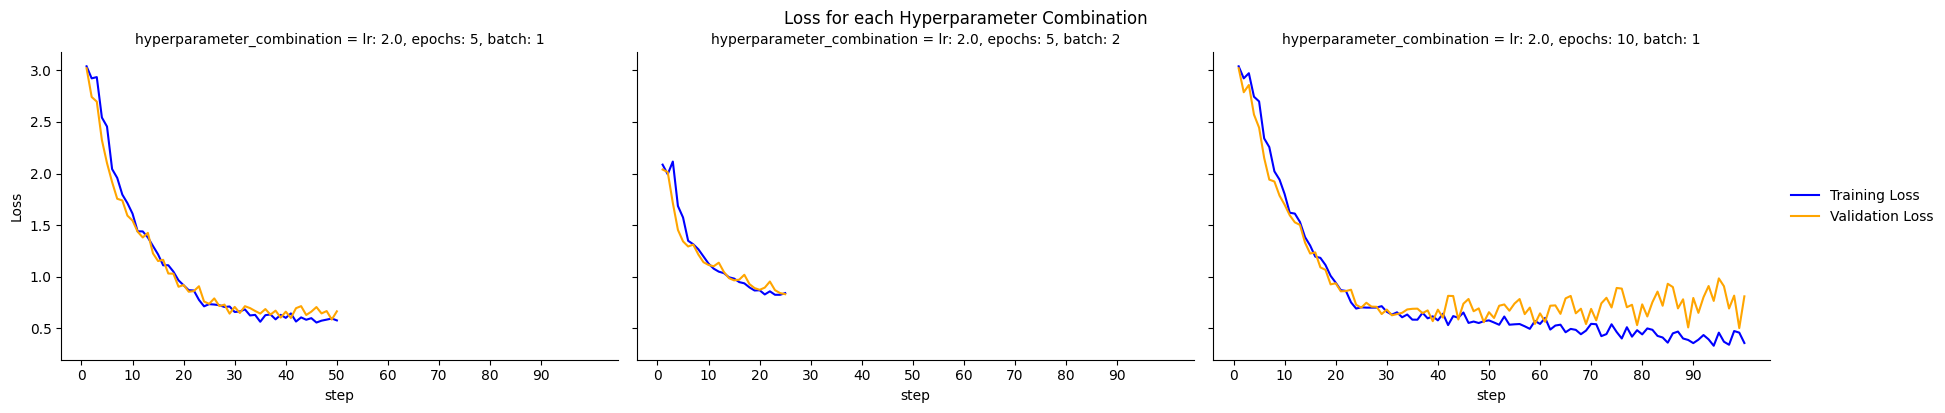

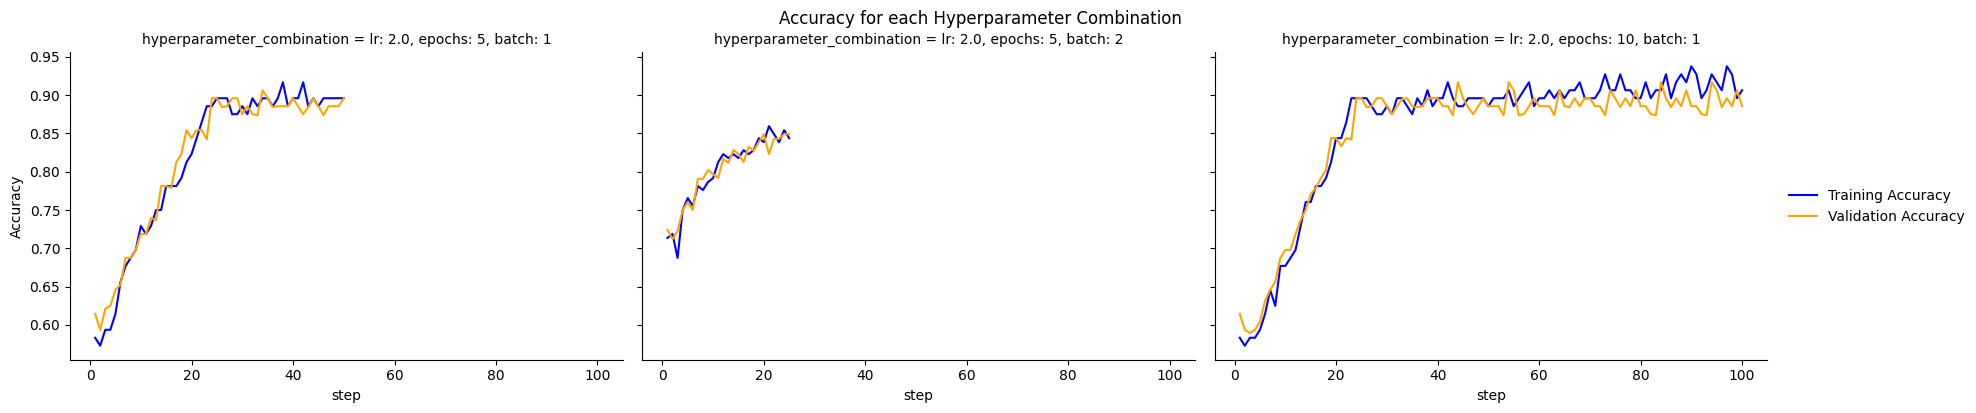

In [22]:
clas_results_metrics_copy = pd.read_csv("results/clas_results_metrics.csv")
clas_results_metrics_copy["learning_rate_multiplier"] = clas_results_metrics_copy["learning_rate_multiplier"].astype(str)

# Create a column to represent each hyperparameter combination
clas_results_metrics_copy["hyperparameter_combination"] = (
    "lr: " + clas_results_metrics_copy["learning_rate_multiplier"].astype(str) +
    ", epochs: " + clas_results_metrics_copy["n_epochs"].astype(str) +
    ", batch: " + clas_results_metrics_copy["batch_size"].astype(str)
)

# delete rows where steps == =
clas_results_metrics_copy = clas_results_metrics_copy[clas_results_metrics_copy["step"] != "="]
clas_results_metrics_copy = clas_results_metrics_copy[clas_results_metrics_copy["step"] != "=="]
clas_results_metrics_copy = clas_results_metrics_copy[clas_results_metrics_copy["step"] != "==="]
# Convert steps to integers
clas_results_metrics_copy["step"] = clas_results_metrics_copy["step"].astype(int)

display(clas_results_metrics_copy.head())

# Plot the losses
# grid of subplots: g with FacetGrid function
g = sns.FacetGrid(clas_results_metrics_copy,
                  col="hyperparameter_combination",
                  col_wrap=3,
                  height=4,
                  aspect=1.5
                  )
g.map(plt.plot, "step", "train_loss", label="Training Loss", color="blue")
g.map(plt.plot, "step", "valid_loss", label="Validation Loss", color="orange")
g.add_legend()
for ax in g.axes.flat:
    ax.set_ylabel("Loss")
    # display every tenth step on the x-axis
    ax.set_xticks(range(0, clas_results_metrics_copy["step"].max(), 10))

g.figure.suptitle('Loss for each Hyperparameter Combination', y=1.02)
plt.show()

# Plot the accuracies
g = sns.FacetGrid(clas_results_metrics_copy, col="hyperparameter_combination", col_wrap=3, height=4, aspect=1.5)
g.map(plt.plot, "step", "train_accuracy", label="Training Accuracy",color="blue")
g.map(plt.plot, "step", "valid_mean_token_accuracy", label="Validation Accuracy", color="orange")
g.add_legend()
for ax in g.axes.flat:
    ax.set_ylabel("Accuracy")

g.figure.suptitle('Accuracy for each Hyperparameter Combination', y=1.02)
plt.show()

# save all_results_metrics_copy as a global variable
clas_results_metrics_copy.to_csv("results/clas_results_metrics_copy.csv")

In [19]:
clas_results_metrics_copy = pd.read_csv("results/clas_results_metrics_copy.csv")

# Find three most minimal losses to choose the best model
min_loss = clas_results_metrics_copy["train_loss"].min()
min_losses = clas_results_metrics_copy["train_loss"].nsmallest(3)
display(min_loss)
display(min_losses)
print(f"Models {min_losses.index} are the models with the lowest losses of {min_losses.values}.")

# Find the model with the smallest training AND validation loss
# Calculate sum of each training and validation loss and find smallest sum
clas_results_metrics_copy["sum_loss"] = clas_results_metrics_copy["train_loss"] + clas_results_metrics_copy["valid_loss"]
min_sum_loss = clas_results_metrics_copy["sum_loss"].min()
min_sum_losses = clas_results_metrics_copy["sum_loss"].nsmallest(3)
display(min_sum_loss)
display(min_sum_losses)
print(f"Models {min_sum_losses.index} are the models with the lowest sum of training and validation losses of {min_sum_losses.values}.")

# save min_sum_losses.index as list of indices
min_sum_losses_indices = min_sum_losses.index.tolist()
print(min_sum_losses_indices)
display(clas_results_metrics_copy.loc[min_sum_losses_indices[0]])
display(clas_results_metrics_copy.loc[min_sum_losses_indices[1]])
display(clas_results_metrics_copy.loc[min_sum_losses_indices[2]])

0.33196

168    0.33196
171    0.34149
164    0.35744
Name: train_loss, dtype: float64

Models Index([168, 171, 164], dtype='int64') are the models with the lowest losses of [0.33196 0.34149 0.35744].


0.89709

163    0.89709
173    0.96251
153    1.01441
Name: sum_loss, dtype: float64

Models Index([163, 173, 153], dtype='int64') are the models with the lowest sum of training and validation losses of [0.89709 0.96251 1.01441].
[163, 173, 153]


Unnamed: 0.1                                                                164
Unnamed: 0                                                                   88
step                                                                         89
train_loss                                                                0.388
train_accuracy                                                          0.91667
valid_loss                                                              0.50909
valid_mean_token_accuracy                                               0.90625
job_id                                           ftjob-jGJxAIA5FlqxDwS1jzsd6rCm
learning_rate_multiplier                                                    2.0
n_epochs                                                                     10
batch_size                                                                    1
status                                                                succeeded
event_ids                     ['ftevent-

Unnamed: 0.1                                                                174
Unnamed: 0                                                                   98
step                                                                         99
train_loss                                                              0.45913
train_accuracy                                                          0.89583
valid_loss                                                              0.50338
valid_mean_token_accuracy                                               0.90625
job_id                                           ftjob-jGJxAIA5FlqxDwS1jzsd6rCm
learning_rate_multiplier                                                    2.0
n_epochs                                                                     10
batch_size                                                                    1
status                                                                succeeded
event_ids                     ['ftevent-

Unnamed: 0.1                                                                154
Unnamed: 0                                                                   78
step                                                                         79
train_loss                                                              0.48258
train_accuracy                                                          0.89583
valid_loss                                                              0.53183
valid_mean_token_accuracy                                               0.90625
job_id                                           ftjob-jGJxAIA5FlqxDwS1jzsd6rCm
learning_rate_multiplier                                                    2.0
n_epochs                                                                     10
batch_size                                                                    1
status                                                                succeeded
event_ids                     ['ftevent-

In [21]:
# print smallest sum of losses of models with combination lr: 5, epochs: 4, batch: 1
display(clas_results_metrics_copy[clas_results_metrics_copy["hyperparameter_combination"] == "lr: 2.0, epochs: 10, batch: 1"])


,Unnamed: 0.1,Unnamed: 0,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name,hyperparameter_combination,sum_loss
75,76,0,1,3.03915,0.58333,3.02060,0.61458,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"['ftevent-3ubvYQAp5sAlJOqKFayb0O9a', 'ftevent-...",['file-PyvSbxYCbVzO1cYgmiDQpH2D'],"lr: 2.0, epochs: 10, batch: 1",6.05975
76,77,1,2,2.92238,0.57292,2.78797,0.59375,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"['ftevent-3ubvYQAp5sAlJOqKFayb0O9a', 'ftevent-...",['file-PyvSbxYCbVzO1cYgmiDQpH2D'],"lr: 2.0, epochs: 10, batch: 1",5.71035
77,78,2,3,2.97217,0.58333,2.85817,0.58947,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"['ftevent-3ubvYQAp5sAlJOqKFayb0O9a', 'ftevent-...",['file-PyvSbxYCbVzO1cYgmiDQpH2D'],"lr: 2.0, epochs: 10, batch: 1",5.83034
78,79,3,4,2.74452,0.58333,2.57167,0.59375,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"['ftevent-3ubvYQAp5sAlJOqKFayb0O9a', 'ftevent-...",['file-PyvSbxYCbVzO1cYgmiDQpH2D'],"lr: 2.0, epochs: 10, batch: 1",5.31619
79,80,4,5,2.69906,0.59375,2.44523,0.60417,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"['ftevent-3ubvYQAp5sAlJOqKFayb0O9a', 'ftevent-...",['file-PyvSbxYCbVzO1cYgmiDQpH2D'],"lr: 2.0, epochs: 10, batch: 1",5.14429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,171,95,96,0.37102,0.90625,0.90839,0.88421,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"['ftevent-3ubvYQAp5sAlJOqKFayb0O9a', 'ftevent-...",['file-PyvSbxYCbVzO1cYgmiDQpH2D'],"lr: 2.0, epochs: 10, batch: 1",1.27941
171,172,96,97,0.34149,0.93750,0.69284,0.89583,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"['ftevent-3ubvYQAp5sAlJOqKFayb0O9a', 'ftevent-...",['file-PyvSbxYCbVzO1cYgmiDQpH2D'],"lr: 2.0, epochs: 10, batch: 1",1.03433
172,173,97,98,0.47434,0.92708,0.81747,0.88542,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"['ftevent-3ubvYQAp5sAlJOqKFayb0O9a', 'ftevent-...",['file-PyvSbxYCbVzO1cYgmiDQpH2D'],"lr: 2.0, epochs: 10, batch: 1",1.29181
173,174,98,99,0.45913,0.89583,0.50338,0.90625,ftjob-jGJxAIA5FlqxDwS1jzsd6rCm,2.0,10,1,succeeded,"['ftevent-3ubvYQAp5sAlJOqKFayb0O9a', 'ftevent-...",['file-PyvSbxYCbVzO1cYgmiDQpH2D'],"lr: 2.0, epochs: 10, batch: 1",0.96251


Cancel or track a fine-tune job or delete a model

In [ ]:
# # List 10 fine-tuning jobs
# client.fine_tuning.jobs.list(limit=10)

# # Retrieve the state of a fine-tune
# client.fine_tuning.jobs.retrieve("ftjob-abc123")

# # Cancel a job
# client.fine_tuning.jobs.cancel("ftjob-abc123")

# # List up to 10 events from a fine-tuning job
# client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-abc123", limit=10)

# # Delete a fine-tuned model (must be an owner of the org the model was created in)
# client.models.delete("ft:gpt-3.5-turbo:acemeco:suffix:abc123")

Using fine-tuned model via Playground or via code

In [18]:
# save json small test set in a list of messages
test_messages = []
with open("data/finetuning_data/small_testing_data_messages.jsonl", "r") as f:
    for line in f:
        test_messages.append(json.loads(line))

# make a request to the new model
for i in range(len(test_messages)):
    completion = client.chat.completions.create(
        model="ft:gpt-3.5-turbo-0125:lse:mig-gen:9rLoNStH",
        messages = test_messages[i]["messages"]
        )
    print(completion.choices[0].message)
    # save the response in a list
    test_messages[i]["messages"].append({"role":"response"})
    test_messages[i]["messages"].append({"content": completion.choices[0].message.content})

# save the responses in a jsonl file
with open("data/finetuning_data/small_testing_data_responses.jsonl", "w") as f:
    for message in test_messages:
        f.write(json.dumps(message) + "\n")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='3734', role='assistant', function_call=None, tool_calls=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='3.0;22.4;25.8;26.0;1.8;20.5;0.1;0.6;17.9;19.5;0.3;17.7;4.0;34.1;2.5;1.5;5.0;7.7;68.7;0.2;1.5;3.3;4.6;4.8;3.8;1.8;14.6;2.8;5.0;3.2;1.1;2.4;44.8;9.4;3.9;0.3;1.4;51.4;6.2;0.1;1.6;0.3;16.5;0.9;5.3;10.5;16.2;9.6;1.6;0.5;3.5;55.7;2.1;15.2;1.7;0.4;0.1;20.3;0.1;5.0;6.8;11.1;33.9;3.5;1.2;1.1;2.1;72.7;2.2;0.7;3.2;16.7;1.1;18.5;1.6;0;3.8;1.6;16.6;2.1;12.2;12.2;5.9;67.3;1.0;0.4;2.5;0.4;55.8;6.8;0.1;1.9;0.3;0 \n', role='assistant', function_call=None, tool_calls=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='35829860', role='assistant', function_call=None, tool_calls=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote of party groups on Regulation of the European Parliament and of the Council strengthening statutory audit for public-interest entities.', role='assistant', function_call=None, tool_calls=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='-2, -2, 2, -2, -2, 2, 2, nan, 2, -2, 2, 2, 2, 2, 2, 1, 2, 2, 2, -2, 2, 2, -2, 2, 2, 2, 2, 2, -2, -2, 2, 2, -2, -2, 2, -2, 2, -2, 2, -2, 2, 2, 2, -1, -2, 2, -2, -1, 2, 2, 2, 2', role='assistant', function_call=None, tool_calls=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='78.846 - 54.168 - 40.00 - 52.747 - 52.73 - 52.963 - 85.00 - 51.616 - 48.081 - 53.52 - 60.974 - 49.047 - 39.992 - 46.43 - 25.811 - 94.40 - 49.048 - 55.137 - 48.604 - 53.93 - 52.072 - 45.928 - 55.22 - 77.46 - 69.405 - 74.003 - 58.47 - 28.151 - 55.774 - 42.70 - 27.395 - 43.497 - 48.725 - 49.259 - 39.718 - 54.558 - 50.483 - 35.733 - 48.394 - 50.00 - 42.00 - 16.476 - 46.756 - 48.463 - 43.465 - 49.877 - 47.991 - 46.488 - 18.878 - 65.504 - 41.311 - 43.267 - 22.25', role='assistant', function_call=None, tool_calls=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote Category: General\nPolitical Direction: Neutral\nFraming: Proposal\nTopic Relevance: Transport\nEPP:  \nS&D:  \nECR:  \nRENEW:  \nLEFT:  \nRIGHT:  \nID:  \nGreens/EFA:', role='assistant', function_call=None, tool_calls=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='79', role='assistant', function_call=None, tool_calls=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='44421331145244461601', role='assistant', function_call=None, tool_calls=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content="Based on the description provided, parties are likely to vote as follows:\nRenew Europe: \nSocialists and Democrats: \nGroup of the European People's Party (Christian Democrats), German Christian Democrats: \nECR Group: \nGroup of the Greens/European Free Alliance: \nIdentity and Democracy Group:\nNon-attached Members: ", role='assistant', function_call=None, tool_calls=None)


Calculate Accuracy of generated answers

In [19]:
test_messages[0]["messages"]

[{'role': 'system',
  'content': 'Imagine you are a member of the European\n         Parliament and based on your years of experience, you are an expert in \n         predicting how the different party groups will vote on a given law. Given\n         a legislative proposal, predict the percentage of votes in favour \n         from each party group. Assess the political \n         direction, wording, framing, and topic relevance of the law to inform your \n         predictions. Determine the type of majority (General, Left, Right, Consensus) \n         likely to support the legislation based on party alignments. Reply with numerical\n         values only.'},
 {'role': 'user',
  'content': "Rail passengers' rights and obligations: PURPOSE: to update EU rules on rail passenger rights in order to better protect users in the event of delays, cancellations or discrimination. PROPOSED ACT: Regulation of the European Parliament and of the Council. ROLE OF THE EUROPEAN PARLIAMENT: the European 

In [ ]:
# get the responses from the jsonl file
# read in jsonl file
only_responses = []
with open("data/finetuning_data/small_testing_data_responses.jsonl", "r") as f:
    test_responses = [json.loads(line) for line in f]
    for i in range(len(test_responses)):
        response = test_responses[i]["messages"][-1]["content"]
        only_responses.append(response)

# Convert list of strings to list of dictionaries
response_dicts = [fu.parse_string_ls_to_dict(item) for item in only_responses]
print(response_dicts)
# Convert list of dictionaries to DataFrame
response_df = pd.DataFrame(response_dicts)

# Convert numeric columns to float
response_df = response_df.apply(pd.to_numeric, errors='ignore')

display(response_df)

[{'Vote ID': '8178EP8', 'ECR%': ' 0.23', 'EPP%': ' 0.67', 'Greens/EFA%': ' 0.6', 'EFD/IDG%': ' 0.43', 'NI%': ' 0', 'REG%': ' 0.3', 'S&D%': ' .444', 'The Left%': ' 0', 'General Majority': ' 0', 'Left Majority': ' 1', 'Right Majority': ' 0', 'Consensus': ' 0'}, {'Vote ID': '10214EP8', 'ECR%': ' 0.23', 'EPP%': ' 0.67', 'Greens/EFA%': ' 0.6', 'EFD/IDG%': ' 0.43', 'NI%': ' 0', 'REG%': ' 0.3', 'S&D%': ' .444', 'The Left%': ' 0', 'General Majority': ' 0', 'Left Majority': ' 1', 'Right Majority': ' 0', 'Consensus': ' 0'}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]


C:\Users\Cäcilia\AppData\Local\Temp\ipykernel_51204\3519599285.py:37: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  response_df = response_df.apply(pd.to_numeric, errors='ignore')


,Vote ID,ECR%,EPP%,Greens/EFA%,EFD/IDG%,NI%,REG%,S&D%,The Left%,General Majority,Left Majority,Right Majority,Consensus
0,8178EP8,0.23,0.67,0.6,0.43,0.0,0.3,0.444,0.0,0.0,1.0,0.0,0.0
1,10214EP8,0.23,0.67,0.6,0.43,0.0,0.3,0.444,0.0,0.0,1.0,0.0,0.0


In [ ]:
# read in testing 
testing = pd.read_csv("data/finetuning_data/testing_data.csv")
#set index of testing data to vote id
testing = testing.set_index("Vote ID")
#display(testing)

# Calculate accuracy
acc, acc_df = fu.get_accuracy_df(testing, response_df, 0.05)
print(acc)

          ECR%  EPP%  Greens/EFA%  EFD/IDG%  NI%  REG%   S&D%  The Left%  \
Vote ID                                                                    
8178EP8   0.23  0.67          0.6      0.43  0.0   0.3  0.444        0.0   
10214EP8  0.23  0.67          0.6      0.43  0.0   0.3  0.444        0.0   

          General Majority  Left Majority  Right Majority  Consensus  
Vote ID                                                               
8178EP8                0.0            1.0             0.0        0.0  
10214EP8               0.0            1.0             0.0        0.0  


In [65]:
# # Generate synthetic dataset of generated party group percentages for ten vote ids
# # party groups constitute the column names of the dataframe, vote ids the index
# # and the values are the percentages of votes for each party group

# # generate random percentages for each party group
# synthetic_data = defaultdict(list)
# for i in range(8):
#     synthetic_data[i] = [random.randint(0, 100) for _ in range(5)]
#     # normalize the percentages
#     sum_percentages = sum(synthetic_data[i])

#     for j in range(5):
#         synthetic_data[i][j] = synthetic_data[i][j] / sum_percentages * 100


# # convert to a dataframe
# synthetic_data_df = pd.DataFrame(synthetic_data)

# # rename column names to ECR%, EPP%, ENF/ID%, Greens/EFA%, NI%, S&D%, REG%
# synthetic_data_df.columns = ["ECR%", "EPP%", "ENF/ID%", "Greens/EFA%", "NI%", "S&D%", "REG%", "The Left%"]

# display(synthetic_data_df)

# # convert to a jsonl file with the following format: [{'role': 'system', 'content': 'Imagine you are a member of the European\n         Parliament and based on your years of experience, you are an expert in \n         predicting how the different party groups will vote on a given law. Given\n         a legislative proposal, predict the percentage of votes in favour \n         from each party group. Assess the political \n         direction, wording, framing, and topic relevance of the law to inform your \n         predictions. Determine the type of majority (General, Left, Right, Consensus) \n         likely to support the legislation based on party alignments. Reply with numerical\n         values only.'},{'role': 'user', 'content': "Rail passengers' rights and obligations: PURPOSE: to update EU rules on rail passenger rights in order to better protect users in the event of delays, cancellations or discrimination. PROPOSED ACT: Regulation of the European Parliament and of the Council. ROLE OF THE EUROPEAN PARLIAMENT: the European Parliament decides in accordance with the ordinary legislative procedure and on an equal footing with the Council. BACKGROUND: by virtue of Regulation (EC) No 1371/2007, which entered into force in December 2009, rail passengers have rights to information, reservations and tickets, assistance, care and compensation in the event of a delay or cancellation, free of charge assistance (for persons with disabilities), compensation in the event of an accident or quick access to a complaint handling system. In its 2013 report on the application of the Regulation, the Commission highlighted certain problematic areas which were confirmed by an impact assessment in 2016/2017. With this proposal to recast the existing legislation, the Commission wishes to better protect passengers no matter where they travel in the EU. It aligns rail with general aspects of passenger rights legislation on other transport modes, notably non-discrimination, contingency planning, disability training, complaint handling and enforcement. IMPACT ASSESSMENT: policy options were broken down, in a sequential approach analysing and comparing costs and benefits and selecting a preferred policy scenario per theme: (i) exemptions; (ii) the applicability of the rights of persons with reduced mobility to all services; (iii) information for persons with reduced mobility; (iv) assistance to persons with reduced mobility; (v) handling of complaints and monitoring of enforcement by national enforcement agencies; (vi) definition of throughticket; (viii) force majeure; (ix) information for all travellers; (x) non-discrimination. CONTENT: the main elements of proposal recasting Regulation (EC) No 1371/2007 are as follows: Uniform application of rules : to date, many Member States have frequently used national exemptions, which deprive travellers to a large extent of their rights. The proposal: removes exemptions for long-distance domestic services by 2020; removes exemptions for cross-border urban, suburban and regional services; requires that Member States grant exemptions only if they can prove that passengers are adequately protected on their territory. The Commission proposal updates the existing rules on rail passenger rights in five key areas: Information and non-discrimination : in order to improve provision of information about passenger rights at booking, the proposal: requires such information to be printed on the ticket or electronically. Notices informing passengers of their rights have to be placed in prominent positions in stations and on board; provides for passengers to be given fuller information on through tickets. Railway undertakings and ticket vendors have to make efforts to offer through tickets. They must prove that they informed passengers where their passenger rights do not apply to the whole journey but only to its segments; introduces a general clause prohibiting any form of discrimination, e.g. based on nationality, residence, location or currency of payment. Better rights for persons with disabilities or reduced mobility : mandatory right to assistance on all services and full compensation for loss or repair of mobility equipment. Relevant information has to be given in accessible formats and rail staff must receive disability awareness training. Enforcement, complaint-handling and sanctions : the proposal clarifies the procedure and deadlines for passengers to lodge complaints. It specifies the responsibilities of national enforcement bodies in cross-border cases and requires them to cooperate effectively. Force majeure : in 2013, the Court of Justice of the European Union ruled that the current Regulation does not allow for railway undertakings to be exempted from compensating passengers for delays caused by force majeure, thus creating a distinction between rail and other modes of transport. The proposal introduces a 'force majeure' clause which would exempt railway undertakings from paying compensation for delays only in very exceptional situations caused by severe weather conditions and natural disasters. DELEGATED ACTS: the proposal contains provisions empowering the Commission to adopt delegated acts in accordance with Article 290 of the Treaty on the Functioning of the European Union."}, {'response': 'ECR: 10%, EPP: 20%, ENF/ID: 30%, Greens/EFA: 10%, NI: 10%, S&D: 10%, REG: 10%, The Left: 10%'}]
# with open("data/finetuning_data/synthetic_data.jsonl", "w") as f:
#     for i in range(8):
#         f.write(json.dumps([{"role": "system", "content": "Imagine you are a member of the European\n         Parliament and based on your years of experience, you are an expert in \n         predicting how the different party groups will vote on a given law. Given\n         a legislative proposal, predict the percentage of votes in favour \n         from each party group. Assess the political \n         direction, wording, framing, and topic relevance of the law to inform your \n         predictions. Determine the type of majority (General, Left, Right, Consensus) \n         likely to support the legislation based on party alignments. Reply with numerical\n         values only."},
#                             {"role": "user", "content": "Rail passengers' rights and obligations:"}
#         ]))

,ECR%,EPP%,ENF/ID%,Greens/EFA%,NI%,S&D%,REG%,The Left
0,17.438692,35.096154,33.064516,11.494253,11.2500,6.111111,16.465863,8.777429
1,25.613079,23.076923,24.596774,59.770115,26.8750,27.777778,28.112450,21.630094
2,14.441417,12.500000,37.096774,4.597701,14.6875,21.111111,0.401606,25.705329
3,26.430518,15.865385,0.000000,24.137931,24.6875,27.777778,29.718876,15.987461
4,16.076294,13.461538,5.241935,0.000000,22.5000,17.222222,25.301205,27.899687


In [41]:
# convert jsonl file to a list of dictionaries
# import json
# import pandas as pd

# response_ls = []
# with open("data/finetuning_data/small_testing_data_responses.jsonl", "r") as f:
#     for line in f:
#         response_ls.append(json.loads(line))

# print(len(response_ls))

# # Initialize an empty DataFrame
# response_df = pd.DataFrame()

# # convert list of dictionaries to a dataframe
# for i in range(len(response_ls)):
#     response_df_part = pd.DataFrame(response_ls[i]["messages"])
#     response_df = pd.concat([response_df, response_df_part], axis=0, ignore_index=True)

# # Pivot the DataFrame to get roles as columns
# response_df = response_df.pivot(columns="role", values="content")

# #response_df = response_df.set_index("Vote_ID")

# display(response_df.head(5))

11


role,NaN,response,system,user
0,NaN,NaN,Imagine you are a member of the European\n ...,NaN
1,NaN,NaN,NaN,Rail passengers' rights and obligations: PURPO...
2,NaN,NaN,NaN,NaN
3,"ECR%: 0.23, EPP%: 0.67, ENF/IDG%: 0.43, Greens...",NaN,NaN,NaN
4,NaN,NaN,Imagine you are a member of the European\n ...,NaN
5,NaN,NaN,NaN,Rail passengers' rights and obligations: PURPO...
6,NaN,NaN,NaN,NaN
7,3734,NaN,NaN,NaN
8,NaN,NaN,Imagine you are a member of the European\n ...,NaN
9,NaN,NaN,NaN,Connecting Europe Facility : PURPOSE: to renew...
